In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.interpolate import griddata

In [2]:
home_folder = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
# we need to coordinates file to access the corner points - glamf/gphif
model_mask_file = home_folder + 'GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,0,:,:]

In [3]:
# left_lon = 0
# right_lon = 20
# top_lat = -10
# bottom_lat = -40 #120579 particles- memory allocation error with np.meshgrid
left_lon = 5
right_lon = 21
top_lat = -15
bottom_lat = -40

delta = 0.0625
# delta = 0.25

lons = np.arange(left_lon, right_lon + delta, delta)
lats = np.arange(bottom_lat, top_lat + delta, delta)
regions_lons, regions_lats = np.meshgrid(lons, lats)
print(regions_lons.shape)

(401, 257)


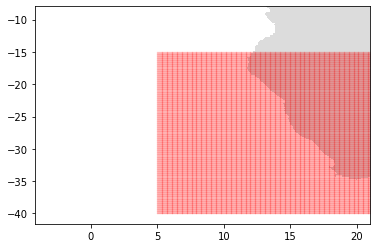

In [4]:
fig = plt.figure()
ax = plt.axes()
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 1250:1750, 1500:], cmap=colormap)
ax.scatter(regions_lons, regions_lats, c='red', s=0.2, alpha=0.1)
plt.show()

Using full matrix (**FULLm**) for ease of FTLE computation- needs 2D grid with defined corners and not coastline. 

In [8]:
np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_0pt0625_FULLm_release_points.npz',
                    Longitude=regions_lons,
                    Latitude=regions_lats)

No need to remove land points

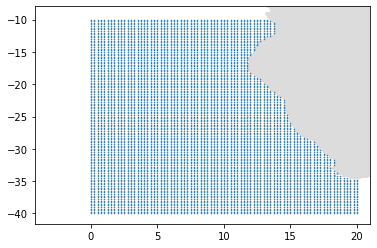

In [11]:
land_val_release = griddata((mask_lon.ravel(), mask_lat.ravel()), mask_land.ravel(),
                            (regions_lons, regions_lats), method='linear', fill_value=0)
bool_mask = land_val_release.astype(bool)

fig = plt.figure()
ax = plt.axes()
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 1250:1750, 1500:], cmap=colormap)


release_lons = regions_lons[bool_mask]
release_lats = regions_lats[bool_mask]

ax.scatter(release_lons, release_lats, s=0.3)
plt.show()

In [12]:
len(release_lons) #120579

7639